In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [ ]:
# Set precision of numpy outputs to 6 decimal places
np.set_printoptions (precision=6, suppress= True)

In [ ]:
# Loading Data
dataset = pd.read_csv ('https://web.iitd.ac.in/~seshan/a1/group12.txt', sep ="\s+",engine='python')

# Using First 20 Data Points

In [ ]:
# Splitting x (independent) and y (dependent) columns
data = dataset.head (20)
x_actual = np.array(data.iloc[:,0])
y_actual = np.array(data.iloc[:,1])

In [ ]:
# Normalizing x and y

x_norm  = ( x_actual- np.mean(x_actual) )/np.std(x_actual)
y_norm = ( y_actual- np.mean(y_actual) )/np.std(y_actual)

In [ ]:
from sklearn import model_selection 
x_train, x_test, y_train, y_test = model_selection.train_test_split (x_norm, y_norm, test_size = 0.4)

<bound method Figure.show of <Figure size 720x360 with 2 Axes>>

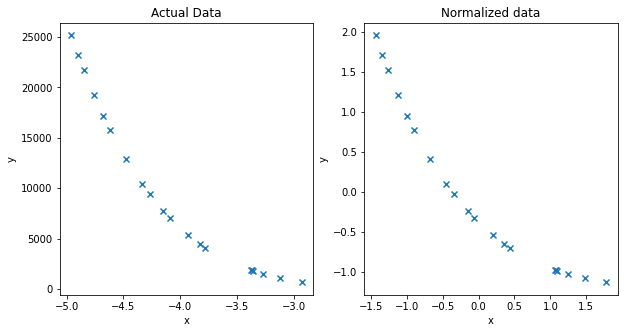

In [ ]:
# Plotting normalized and actual data to show that normalization does not affect the trend in data

fig, axis = plt.subplots (1,2, figsize = (10,5))
axis[0].scatter (x_actual, y_actual, marker  = 'x')
axis[0].set_title ("Actual Data")
axis[0].set (xlabel = 'x', ylabel = 'y')

axis[1].scatter (x_norm, y_norm, marker = 'x')
axis[1].set_title ("Normalized data")
axis[1].set (xlabel = 'x', ylabel = 'y')

fig.show

<bound method Figure.show of <Figure size 720x360 with 2 Axes>>

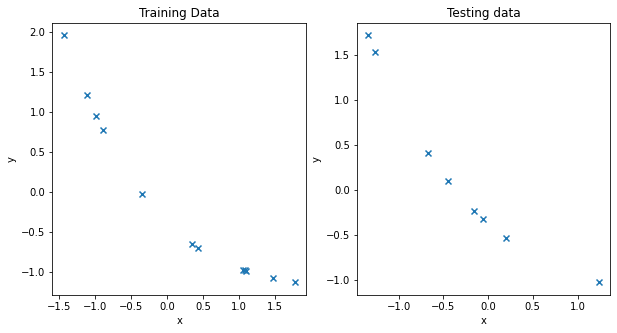

In [ ]:
# Plotting training and testing data points

fig, axis = plt.subplots (1,2, figsize = (10,5))
axis[0].scatter (x_train, y_train, marker  = 'x')
axis[0].set_title ("Training Data")
axis[0].set (xlabel = 'x', ylabel = 'y')

axis[1].scatter (x_test, y_test, marker = 'x')
axis[1].set_title ("Testing data")
axis[1].set (xlabel = 'x', ylabel = 'y')

fig.show

## Defining the hypothesis and different Error Measures

In [ ]:
# Defining hypothesis for regression
def hypothesis (X, w):
    return np.matmul(X, w)

In [ ]:
# Defining RMSE (Root Mean Square Error) and its gradient

# Set reg = True to introduce regularization in any error measure and its gradient

def rmse (X, y, w, regp =0.8, reg = False):
    N = len (y)
    squared_error = math.sqrt (np.sum ( (np.matmul(X, w)-y)**2 ) /N) 
    if reg is True:
        reg_term = 0
        for i in range (1, len(w)):
            reg_term = reg_term + (w[i]**2)
        reg_error = (squared_error) +  (regp/N)*reg_term
        return reg_error

    rmse = squared_error
    return rmse

def rmse_gradient (X, y, w, regp = 0.8, reg = False):
    N = len (y)
    if reg is True:
        gradient = (np.matmul (X.T, np.matmul(X, w)-y))
        for i in range (1, len(w)):
            gradient[i] = gradient[i] + 2*(regp/N)*w[i]
        return gradient/ (rmse(X, y, w, regp, reg=True))

    return (np.matmul (X.T, np.matmul(X, w)-y))/ (N*rmse(X, y, w))

In [ ]:
# Defining MAE (Mean Absolute Error) and its gradient

def mae (X, y, w, regp = 0.8, reg= False):
    N = len (y)
    y_predicted = hypothesis (X,w)
    absolute_error = np.absolute(y_predicted - y)
    if reg is True:
        reg_term = 0
        for i in range (1, len(w)):
            reg_term = reg_term + (w[i]**2)
        reg_error = np.sum (absolute_error) +  regp*reg_term
        return reg_error/N

    return np.sum (absolute_error)/N

def mae_gradient (X, y, w, regp = 0.8, reg = False):
    N = len (y)
    y_predicted = hypothesis (X,w)
    
    gradient = np.matmul (X.T, np.sign (y_predicted -y))
    if reg is True:
        for i in range (1, len(w)):
            gradient[i] = gradient[i] + 2*(regp/N)*w[i]

    return (gradient)/N

In [ ]:
# Defining Huber Error and its gradient

def huber (X, y, w, regp=0.8, reg = False, delta = 0.08):
    y_predicted = hypothesis (X, w)
    huber_loss = 0
    for i in range (len (y)):
        abs_error = abs (y_predicted[i]-y[i])
        if (abs_error <= delta):
            huber_loss += 0.5*(abs_error**2)
        else:
            huber_loss += delta*abs_error - 0.5*(delta**2)

    if reg is True:
        reg_term = 0
        for i in range (1, len(w)):
            reg_term = reg_term + (w[i]**2)
        reg_error = huber_loss +  (regp)*reg_term
        return reg_error/len(y)

    return huber_loss

def huber_gradient (X, y, w, regp=0.8, reg = False, delta = 0.08):
    N = len (y)
    y_predicted = hypothesis (X, w)
    sign_matrix = np.sign (y_predicted - y)
    abs_error = np.abs (y_predicted - y)

    m = len (w)
    gradient = []
    for i in range(m):
        grad = 0
        for j in range (N):
            if (abs_error[i] <= delta):
                grad += (y_predicted[j] -y[j])* X[j, i]
            else:
                grad += delta*X[j,i]*sign_matrix[j]
        gradient.append(grad)
    gradient = np.array (gradient)

    if reg is True:
        for i in range (1, len(w)):
            gradient[i] = gradient[i] + 2*(regp/N)*w[i]

    return gradient

## Defining Goodness-of-Fit Measures

In [ ]:
# Defining 2 goodness of fit measures: MSE-Score and R2-Score

def mse_score (y_actual, y_predicted):
    square_errs = np.sum((y_predicted - y_actual)**2)
    return square_errs/len(y_actual)

def r2_score (y_actual, y_predicted):
    mean_predicted = np.mean (y_predicted)
    total_sum_squares = np.sum ((y_predicted- mean_predicted)**2)
    residual_sum_square = np.sum ((y_predicted - y_actual)**2)

    r2 = 1-(residual_sum_square/ total_sum_squares) 
    return r2*100

## Gradient Descent and Curve Fitting 

In [ ]:
# General Gradient Descent Algorithm for all the error measures

# Error measures can be specified using 'grad' parameters:
# 'grad' takes values 'RMSE' (default), 'MAE' and 'HUBER' to specify the error measure to be used

def gradientDescent(X, y, w, alpha=0.1, num_iter=5000, grad= 'RMSE', regp = 0.8, reg = False):
    J=[]
    k=0
    while k < num_iter: 
        if (grad == 'RMSE'):
            j = rmse(X, y, w, regp, reg)
            gradient = rmse_gradient (X, y, w, regp, reg)
        if (grad == 'MAE'):
            j = mae(X, y, w, regp, reg)
            gradient = mae_gradient (X, y, w, regp, reg)
        if (grad == 'HUBER'):
            j = huber (X, y, w , regp, reg, delta = 0.08)
            gradient = huber_gradient (X, y, w, regp, reg, delta = 0.08)
            
        J.append(j)
    
# The value of alpha reduces by half where the gradient tries to diverge out
        if J[k]-J[k-1]>0:
            alpha = alpha/2
            J.pop()
            J.pop()
            k = k-1
            w = w - alpha*gradient
            continue
            
        w = w - alpha*gradient # Updating the weight vector

        if J[k-1]-J[k] < 1e-6 and J[k-1]-J[k] > 0 and k>0:
            print ("Converged at k = ", k)
            break
        k += 1
    return J, w

In [ ]:
# Defining the find the optimum fit for given data
# Returns following quantities:
    # J : Value of E_in (error) at each iteration to help visualize that gradient descent is moving in the right direction
    # w : Optimal weight vector
    # X : Input Design Matrix whose number of columns vary with the degree of polynomial to be fitted
    # The plot of actual data points and fitted polynomial     

def curve_fit (x, y, alpha=0.1, iter = 3000 ,degree=2, grad='RMSE', regp =  0.8, reg = False):
    N = len (x)
    X = np.c_ [np.ones(N), x]

    for i in range (2,degree+1):
        X = np.c_[X, x**i]

    w = np.zeros (degree+1)

    J, w = gradientDescent(X, y, w, alpha, iter, grad, regp, reg)
    print ("Optimal w =", w)
    print ("Normalized ", grad, " Error (%) = ", J[-1]*100)
    print ()
    
    x_line = np.arange(min(x), max(x), 0.1)
    y_line = w[0]
    for i in range (1,degree+1):
        y_line += w[i]* (x_line**i)

    plt.scatter (x, y, color ='blue')
    plt.plot(x_line, y_line, color='red')
    plt.xlabel ('x')
    plt.ylabel ('y')
    plt.title ("Degree = " + str (degree) + ", Error Measure Used = " + str (grad))
    plt.show
    
    return J, w, X

In [ ]:
# Function to predict the output for a given weight vector (w) and degree. 
# This is used to predict the output for testing data

def predict (x, w, degree):
    N = len (x)
    X = np.c_ [np.ones(N), x]

    for i in range (2,degree+1):
        X = np.c_[X, x**i]
    return hypothesis (X, w)

def plot (x, y, w, degree):
    x_line = np.arange(min(x), max(x), 0.1)
    y_line = w[0]
    for i in range (1,degree+1):
        y_line += w[i]* (x_line**i)

    plt.scatter (x, y, color ='blue')
    plt.plot(x_line, y_line, color='red')
    plt.xlabel ('x')
    plt.ylabel ('y')
    plt.show

In [ ]:
# To find the variance in data
def var (y_predicted, y_actual):
    return np.var (y_actual-y_predicted)

## Using Polynomial Curve Fitting on training data for different Error Measures and degrees

### Degree = 1

Converged at k =  45
Optimal w = [ 0.000521 -0.908104]
Normalized  MAE  Error (%) =  22.246529680815815



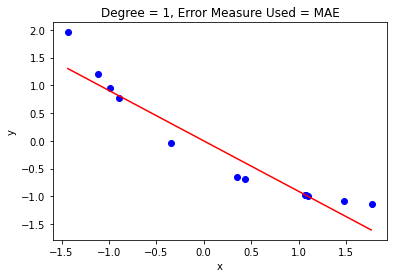

In [ ]:
errors_mae1, w_mae1, X_mae1 =  curve_fit (x_train, y_train, degree = 1, grad = 'MAE')

Converged at k =  24
Optimal w = [ 0.056171 -0.922194]
Normalized  RMSE  Error (%) =  29.550906678096332



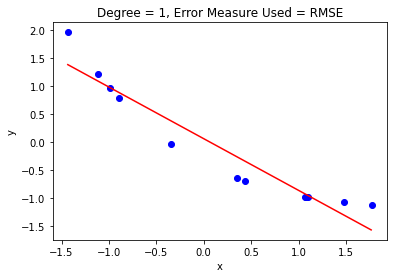

In [ ]:
errors_rmse1, w_rmse1, X_rmse1 =  curve_fit (x_train, y_train, degree = 1, grad = 'RMSE')

Converged at k =  23
Optimal w = [ 0.016   -0.91532]
Normalized  HUBER  Error (%) =  18.370454332378948



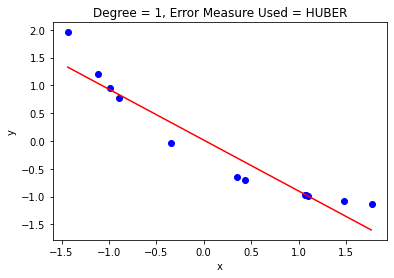

In [ ]:
errors_hub1, w_hub1, X_hub1 =  curve_fit (x_train, y_train, degree = 1, grad = 'HUBER')

In [ ]:
print ("Optimal Weights :")
print ("MAE\t", w_mae1)
print ("RMSE\t", w_rmse1)
print ("HUBER\t", w_hub1)

Optimal Weights :
MAE	 [ 0.000521 -0.908104]
RMSE	 [ 0.056171 -0.922194]
HUBER	 [ 0.016   -0.91532]


### Degree = 2 

Converged at k =  49
Optimal w = [-0.311133 -0.976725  0.308468]
Normalized  MAE  Error (%) =  4.895741744245175



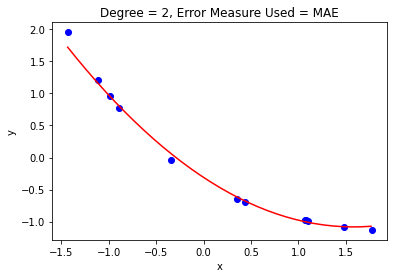

In [ ]:
errors_mae2, w_mae2, X_mae2 =  curve_fit (x_train, y_train, degree = 2, grad = 'MAE')

Converged at k =  34
Optimal w = [-0.343526 -1.015669  0.350816]
Normalized  RMSE  Error (%) =  6.147440037196442



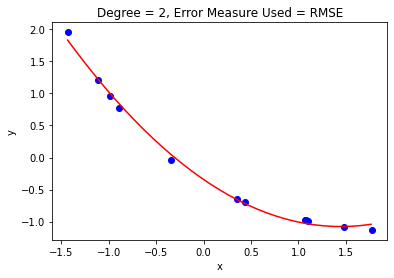

In [ ]:
errors_rmse2, w_rmse2, X_rmse2 =  curve_fit (x_train, y_train, degree = 2, grad = 'RMSE')

Converged at k =  44
Optimal w = [-0.339399 -1.014979  0.348083]
Normalized  HUBER  Error (%) =  2.1680295562854135



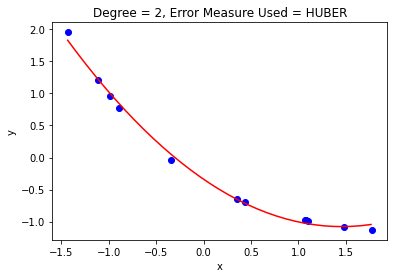

In [ ]:
errors_hub2, w_hub2, X_hub2 =  curve_fit (x_train, y_train, degree = 2, grad = 'HUBER')

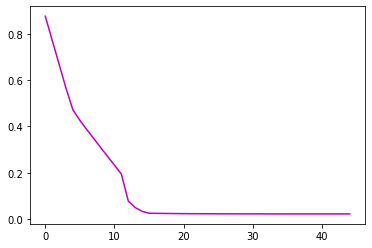

In [ ]:
# Checking Whether gradient descent is moving in the right direction or not

plt.plot (list(range(0, len(errors_hub2))), errors_hub2, 'm')

In [ ]:
print ("Optimal Weights :")
print ("MAE\t", w_mae2)
print ("RMSE\t", w_rmse2)
print ("HUBER\t", w_hub2)

Optimal Weights :
MAE	 [-0.311133 -0.976725  0.308468]
RMSE	 [-0.343526 -1.015669  0.350816]
HUBER	 [-0.339399 -1.014979  0.348083]


## Overfitting, Best-fit and Underfitting

Converged at k =  24
Optimal w = [ 0.056171 -0.922194]
Normalized  RMSE  Error (%) =  29.550906678096332

Training R2-Score 91.82859270255679
Testing R2-Score 84.36794158210633


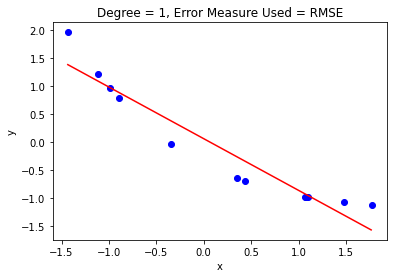

In [ ]:
errors_rmse1, w_rmse1, X_rmse1 =  curve_fit (x_train, y_train, degree = 1, grad = 'RMSE')
y_pred_train = hypothesis (X_rmse1, w_rmse1)
y_pred_test = predict (x_test, w_rmse1, 1)
print ("Training R2-Score", r2_score (y_pred_train, y_train))
print ("Testing R2-Score", r2_score (y_pred_test, y_test))

Converged at k =  34
Optimal w = [-0.343526 -1.015669  0.350816]
Normalized  RMSE  Error (%) =  6.147440037196442

Training R2-Score 99.64638256917927
Testing R2-Score 99.58474204094173


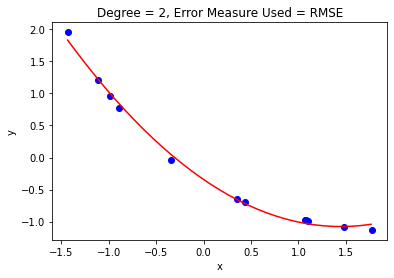

In [ ]:
errors_rmse2, w_rmse2, X_rmse2 =  curve_fit (x_train, y_train, degree = 2, grad = 'RMSE')
y_pred_train = hypothesis (X_rmse2, w_rmse2)
y_pred_test = predict (x_test, w_rmse2, 2)
print ("Training R2-Score", r2_score (y_pred_train, y_train))
print ("Testing R2-Score", r2_score (y_pred_test, y_test))

Converged at k =  1072
Optimal w = [-0.378915 -0.875184  0.376517 -0.088282  0.011083]
Normalized  RMSE  Error (%) =  0.06295691955226251

Training R2-Score 99.99996235648405
Testing R2-Score 99.99996168770832


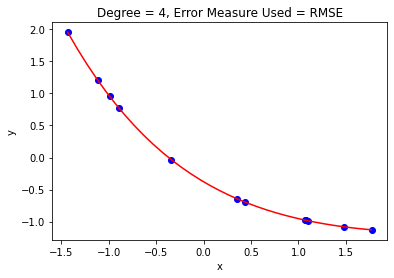

In [ ]:
errors_rmse4, w_rmse4, X_rmse4 =  curve_fit (x_train, y_train, degree = 4, grad = 'RMSE')
y_pred_train = hypothesis (X_rmse4, w_rmse4)
y_pred_test = predict (x_test, w_rmse4, 4)
print ("Training R2-Score", r2_score (y_pred_train, y_train))
print ("Testing R2-Score", r2_score (y_pred_test, y_test))

## Estimate of Noise Variance
Using best-fit, that is second order polynomial

In [ ]:
y_predicted_second_order = hypothesis (X_rmse2, w_rmse2)
print ("Normalized Variance Estimate, =", var (y_predicted_second_order, y_train))

Normalized Variance Estimate, = 0.0037789330281773445


## Introducing Regularisation to the overfitting case:

Converged at k =  1072
Optimal w = [-0.378915 -0.875184  0.376517 -0.088282  0.011083]
Normalized  RMSE  Error (%) =  0.06295691955226251

Training R2-Score 99.99996235648405
Testing R2-Score 99.99996168770832


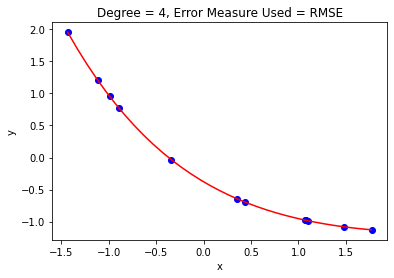

In [ ]:
errors_nonreg, w_nonreg, X_nonreg = curve_fit (x_train, y_train, degree = 4, grad = 'RMSE')
y_nonreg_train = hypothesis (X_nonreg, w_nonreg)
y_nonreg_test = predict (x_test, w_nonreg, 4)
print ("Training R2-Score", r2_score (y_nonreg_train, y_train))
print ("Testing R2-Score", r2_score (y_nonreg_test, y_test))

Converged at k =  1037
Optimal w = [-0.347189 -0.793233  0.29052  -0.137303  0.048201]
Normalized  RMSE  Error (%) =  9.526583001391407

Training R2-Score 99.89162523659837
Testing R2-Score 99.91877397785268


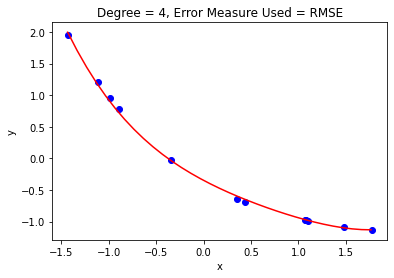

In [ ]:
errors_reg, w_reg, X_reg = curve_fit (x_train, y_train, degree = 4, grad = 'RMSE', regp = 1, reg = True)
y_reg_train = hypothesis (X_reg, w_reg)
y_reg_test = predict (x_test, w_reg, 4)
print ("Training R2-Score", r2_score (y_reg_train, y_train))
print ("Testing R2-Score", r2_score (y_reg_test, y_test))

In [ ]:
def getCoord (x, w, degree):
    x_line = np.arange(min(x), max(x), 0.1)
    y_line = w[0]
    for i in range (1,degree+1):
        y_line += w[i]* (x_line**i)
    return x_line, y_line

<bound method Figure.show of <Figure size 720x360 with 4 Axes>>

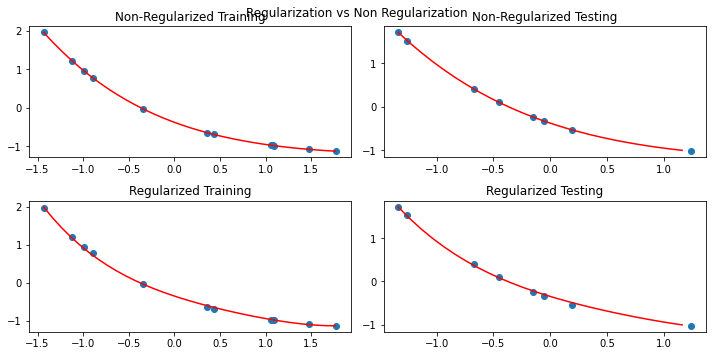

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
fig.suptitle("Regularization vs Non Regularization")
ax[0][0].scatter (x_train, y_train)
x_nonreg_train, y_nonreg_train = getCoord (x_train, w_nonreg, 4)
ax[0][0].plot (x_nonreg_train, y_nonreg_train, color ='r')
ax[0][0].set_title ("Non-Regularized Training")

ax[0][1].scatter (x_test, y_test)
x_nonreg_test, y_nonreg_test = getCoord (x_test, w_nonreg, 4)
ax[0][1].plot (x_nonreg_test, y_nonreg_test, color ='r')
ax[0][1].set_title ("Non-Regularized Testing")

ax[1][0].scatter (x_train, y_train)
x_reg_train, y_reg_train = getCoord (x_train, w_reg, 4)
ax[1][0].plot (x_reg_train, y_reg_train, color ='r')
ax[1][0].set_title ("Regularized Training")

ax[1][1].scatter (x_test, y_test)
x_reg_test, y_reg_test = getCoord (x_test, w_reg, 4)
ax[1][1].plot (x_reg_test, y_reg_test, color ='r')
ax[1][1].set_title ("Regularized Testing")
fig.tight_layout()
fig.show

In [ ]:
y_predicted_second_order_reg = hypothesis (X_reg, w_reg)
print ("Normalized Variance Estimate after regularisation, =", var (y_predicted_second_order_reg, y_train))

Normalized Variance Estimate after regularisation, = 0.0011581668191851008


# Using Full Dataset

In [ ]:
# Splitting x (independent) and y (dependent) columns
data = dataset
x_actual = np.array(data.iloc[:,0])
y_actual = np.array(data.iloc[:,1])

In [ ]:
# Normalizing x and y

x_norm  = ( x_actual- np.mean(x_actual) )/np.std(x_actual)
y_norm = ( y_actual- np.mean(y_actual) )/np.std(y_actual)

In [ ]:
from sklearn import model_selection 
x_train, x_test, y_train, y_test = model_selection.train_test_split (x_norm, y_norm, test_size = 0.4)

<bound method Figure.show of <Figure size 720x360 with 2 Axes>>

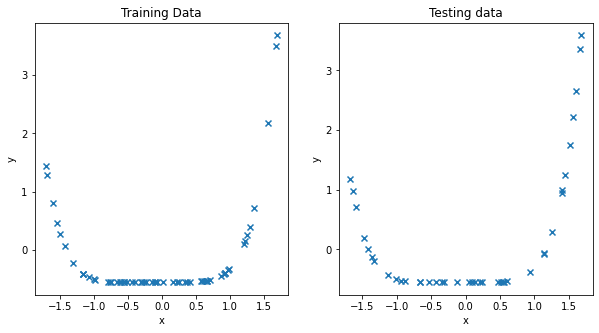

In [ ]:
# Plotting training and testing data points

fig, axis = plt.subplots (1,2, figsize = (10,5))
axis[0].scatter (x_train, y_train, marker  = 'x')
axis[0].set_title ("Training Data")
axis[0].set (xlabel = 'x', ylabel = 'y')

axis[1].scatter (x_test, y_test, marker = 'x')
axis[1].set_title ("Testing data")
axis[1].set (xlabel = 'x', ylabel = 'y')

fig.show

## Using Polynomial Curve Fitting on training data for different Error Measures and degrees

### Degree = 2

Converged at k =  42
Optimal w = [-0.665781  0.100541  0.488363]
Normalized  MAE  Error (%) =  26.074902917675015



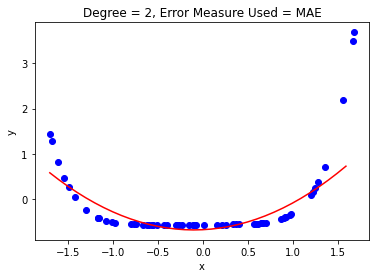

In [ ]:
errors_mae2, w_mae2, X_mae2 =  curve_fit (x_train, y_train, degree = 2, grad = 'MAE')

Converged at k =  79
Optimal w = [-0.874719  0.307522  0.854255]
Normalized  RMSE  Error (%) =  43.45770906517924



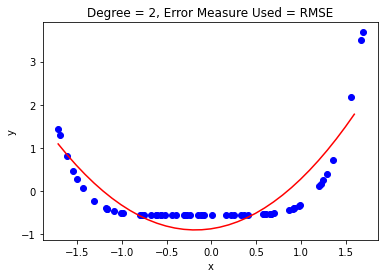

In [ ]:
errors_rmse2, w_rmse2, X_rmse2 =  curve_fit (x_train, y_train, degree = 2, grad = 'RMSE')

Converged at k =  92
Optimal w = [-0.671738  0.106474  0.495237]
Normalized  HUBER  Error (%) =  108.2567194295851



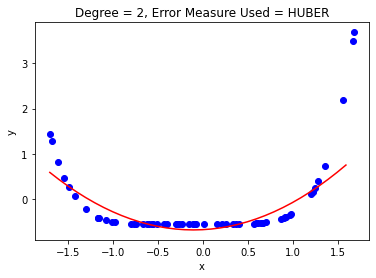

In [ ]:
errors_hub2, w_hub2, X_hub2 =  curve_fit (x_train, y_train, degree = 2, grad = 'HUBER')

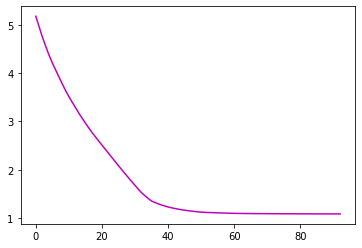

In [ ]:
plt.plot (list(range(0, len(errors_hub2))), errors_hub2, 'm')

In [ ]:
print ("Optimal Weights :")
print ("MAE\t", w_mae2)
print ("RMSE\t", w_rmse2)
print ("HUBER\t", w_hub2)

Optimal Weights :
MAE	 [-0.665781  0.100541  0.488363]
RMSE	 [-0.874719  0.307522  0.854255]
HUBER	 [-0.671738  0.106474  0.495237]


### Degree =4

Converged at k =  59
Optimal w = [-0.542266 -0.032862 -0.204108  0.179083  0.382197]
Normalized  MAE  Error (%) =  7.291565040813477



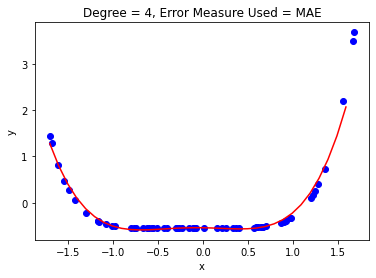

In [ ]:
errors_mae4, w_mae4, X_mae4 =  curve_fit (x_train, y_train, degree = 4, grad = 'MAE')

Converged at k =  422
Optimal w = [-0.489793 -0.157396 -0.477228  0.289367  0.524538]
Normalized  RMSE  Error (%) =  7.744808450552886



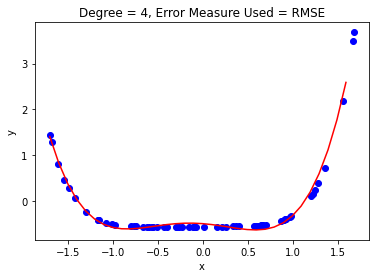

In [ ]:
errors_rmse4, w_rmse4, X_rmse4 =  curve_fit (x_train, y_train, degree = 4, grad = 'RMSE')

Converged at k =  715
Optimal w = [-0.647969 -0.1017    0.145807  0.263559  0.278907]
Normalized  HUBER  Error (%) =  49.02206730444593



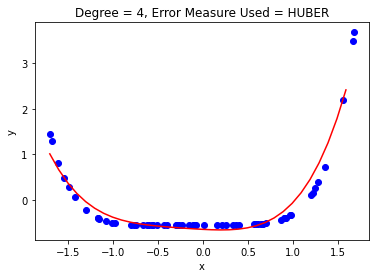

In [ ]:
errors_hub4, w_hub4, X_hub4 =  curve_fit (x_train, y_train, degree = 4, grad = 'HUBER')

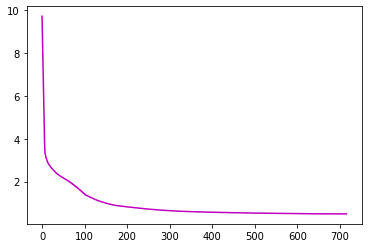

In [ ]:
plt.plot (list(range(0, len(errors_hub4))), errors_hub4, 'm')

In [ ]:
print ("Optimal Weights :")
print ("MAE\t", w_mae4)
print ("RMSE\t", w_rmse4)
print ("HUBER\t", w_hub4)

Optimal Weights :
MAE	 [-0.542266 -0.032862 -0.204108  0.179083  0.382197]
RMSE	 [-0.489793 -0.157396 -0.477228  0.289367  0.524538]
HUBER	 [-0.647969 -0.1017    0.145807  0.263559  0.278907]


## Degree=6

Converged at k =  677
Optimal w = [-0.343311  0.0098   -0.130608  0.024336 -0.034697  0.077735  0.153413]
Normalized  MAE  Error (%) =  11.25883417716502



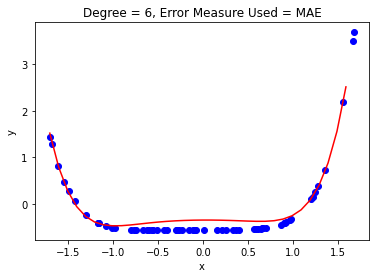

In [ ]:
errors_mae6, w_mae6, X_mae6 =  curve_fit (x_train, y_train, degree = 6, grad = 'MAE')

Converged at k =  871
Optimal w = [-0.543434  0.003029 -0.046766  0.013736  0.059829  0.083936  0.116992]
Normalized  RMSE  Error (%) =  0.555310484291295



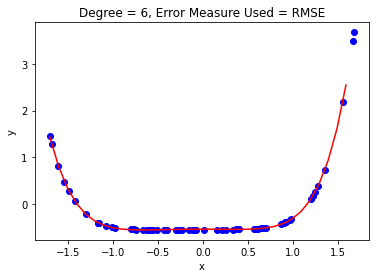

In [ ]:
errors_rmse6, w_rmse6, X_rmse6 =  curve_fit (x_train, y_train, degree = 6, grad = 'RMSE')

In [ ]:
print ("Optimal Weights :")
print ("MAE\t", w_mae6)
print ("RMSE\t", w_rmse6)


Optimal Weights :
MAE	 [-0.343311  0.0098   -0.130608  0.024336 -0.034697  0.077735  0.153413]
RMSE	 [-0.543434  0.003029 -0.046766  0.013736  0.059829  0.083936  0.116992]


## Overfitting, Best-fit and Underfitting

Converged at k =  79
Optimal w = [-0.874719  0.307522  0.854255]
Normalized  RMSE  Error (%) =  43.45770906517924

Training R2-Score 75.92162281671568
Testing R2-Score 82.92278435970223


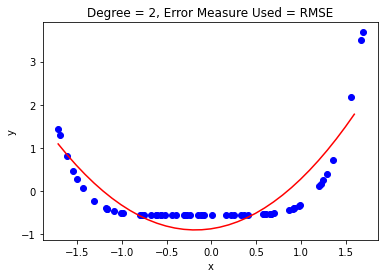

In [ ]:
errors_rmse2, w_rmse2, X_rmse2 =  curve_fit (x_train, y_train, degree = 2, grad = 'RMSE')
y_pred_train = hypothesis (X_rmse2, w_rmse2)
y_pred_test = predict (x_test, w_rmse2, 2)
print ("Training R2-Score", r2_score (y_pred_train, y_train))
print ("Testing R2-Score", r2_score (y_pred_test, y_test))

Converged at k =  422
Optimal w = [-0.489793 -0.157396 -0.477228  0.289367  0.524538]
Normalized  RMSE  Error (%) =  7.744808450552886

Training R2-Score 99.23527455992814
Testing R2-Score 99.36942642096498


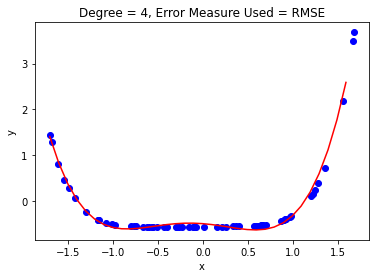

In [ ]:
errors_rmse4, w_rmse4, X_rmse4 =  curve_fit (x_train, y_train, degree = 4, grad = 'RMSE')
y_pred_train = hypothesis (X_rmse4, w_rmse4)
y_pred_test = predict (x_test, w_rmse4, 4)
print ("Training R2-Score", r2_score (y_pred_train, y_train))
print ("Testing R2-Score", r2_score (y_pred_test, y_test))

Converged at k =  871
Optimal w = [-0.543434  0.003029 -0.046766  0.013736  0.059829  0.083936  0.116992]
Normalized  RMSE  Error (%) =  0.555310484291295

Training R2-Score 99.99606877344604
Testing R2-Score 99.99734995508446


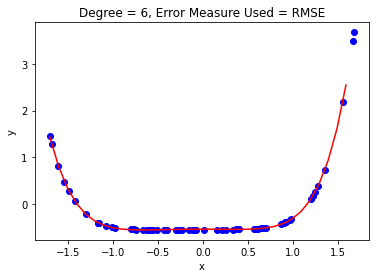

In [ ]:
errors_rmse6, w_rmse6, X_rmse6 =  curve_fit (x_train, y_train, degree = 6, grad = 'RMSE')
y_pred_train = hypothesis (X_rmse6, w_rmse6)
y_pred_test = predict (x_test, w_rmse6, 6)
print ("Training R2-Score", r2_score (y_pred_train, y_train))
print ("Testing R2-Score", r2_score (y_pred_test, y_test))

## Estimate of Noise Variance
Using best-fit, that is fourth order polynomial

In [ ]:
y_predicted_fourth_order = hypothesis (X_rmse4, w_rmse4)
print ("Normalized Variance Estimate, =", var (y_predicted_fourth_order, y_train))

Normalized Variance Estimate, = 0.0059980047440085765


## Introducing Regularisation to the overfitting case:

Converged at k =  871
Optimal w = [-0.543434  0.003029 -0.046766  0.013736  0.059829  0.083936  0.116992]
Normalized  RMSE  Error (%) =  0.555310484291295

Training R2-Score 99.99606877344604
Testing R2-Score 99.99734995508446


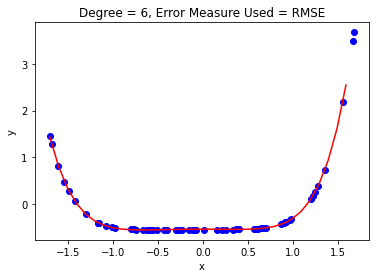

In [ ]:
errors_nonreg, w_nonreg, X_nonreg = curve_fit (x_train, y_train, degree = 6, grad = 'RMSE')
y_nonreg_train = hypothesis (X_nonreg, w_nonreg)
y_nonreg_test = predict (x_test, w_nonreg, 6)
print ("Training R2-Score", r2_score (y_nonreg_train, y_train))
print ("Testing R2-Score", r2_score (y_nonreg_test, y_test))

Converged at k =  1099
Optimal w = [-0.545139  0.002677 -0.040953  0.01416   0.055918  0.083823  0.117696]
Normalized  RMSE  Error (%) =  0.5388346436553269

Training R2-Score 99.99686885846616
Testing R2-Score 99.99783188137603


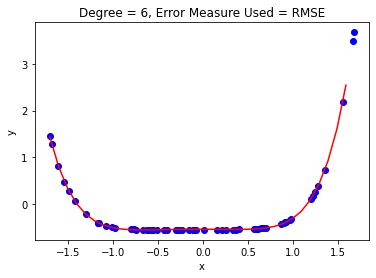

In [ ]:
errors_reg, w_reg, X_reg = curve_fit (x_train, y_train, degree = 6, grad = 'RMSE', regp = 1, reg = True)
y_reg_train = hypothesis (X_reg, w_reg)
y_reg_test = predict (x_test, w_reg, 6)
print ("Training R2-Score", r2_score (y_reg_train, y_train))
print ("Testing R2-Score", r2_score (y_reg_test, y_test))

In [ ]:
def getCoord (x, w, degree):
    x_line = np.arange(min(x), max(x), 0.1)
    y_line = w[0]
    for i in range (1,degree+1):
        y_line += w[i]* (x_line**i)
    return x_line, y_line

<bound method Figure.show of <Figure size 720x360 with 4 Axes>>

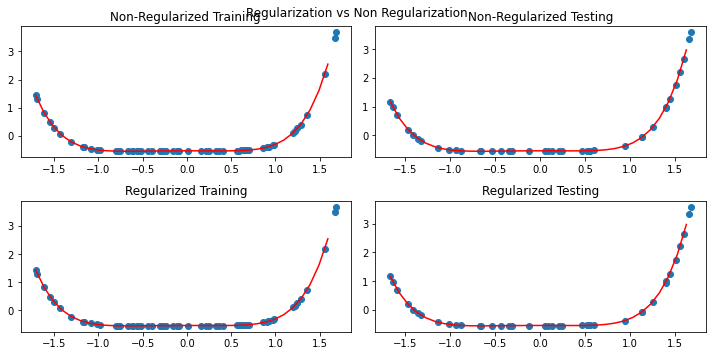

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
fig.suptitle("Regularization vs Non Regularization")
ax[0][0].scatter (x_train, y_train)
x_nonreg_train, y_nonreg_train = getCoord (x_train, w_nonreg, 6)
ax[0][0].plot (x_nonreg_train, y_nonreg_train, color ='r')
ax[0][0].set_title ("Non-Regularized Training")

ax[0][1].scatter (x_test, y_test)
x_nonreg_test, y_nonreg_test = getCoord (x_test, w_nonreg, 6)
ax[0][1].plot (x_nonreg_test, y_nonreg_test, color ='r')
ax[0][1].set_title ("Non-Regularized Testing")

ax[1][0].scatter (x_train, y_train)
x_reg_train, y_reg_train = getCoord (x_train, w_reg, 6)
ax[1][0].plot (x_reg_train, y_reg_train, color ='r')
ax[1][0].set_title ("Regularized Training")

ax[1][1].scatter (x_test, y_test)
x_reg_test, y_reg_test = getCoord (x_test, w_reg, 6)
ax[1][1].plot (x_reg_test, y_reg_test, color ='r')
ax[1][1].set_title ("Regularized Testing")
fig.tight_layout()
fig.show

In [ ]:
y_predicted_sixth_order_reg = hypothesis (X_reg, w_reg)
print ("Normalized Variance Estimate after regularisation, =", var (y_predicted_sixth_order_reg, y_train))

Normalized Variance Estimate after regularisation, = 2.455250338634971e-05
